# Code to transmit the Data to the FPGA

In [1]:
import serial.tools.list_ports
import matplotlib.pyplot as plt
ports = serial.tools.list_ports.comports()
%matplotlib widget

for port, desc, hwid in sorted(ports):
        print("{}: {} [{}]".format(port, desc, hwid))

COM4: Standard Serial over Bluetooth link (COM4) [BTHENUM\{00001101-0000-1000-8000-00805F9B34FB}_LOCALMFG&0002\8&2907864F&0&E8EECC6F76A6_C00000000]
COM5: Standard Serial over Bluetooth link (COM5) [BTHENUM\{00001101-0000-1000-8000-00805F9B34FB}_LOCALMFG&0000\8&2907864F&0&000000000000_00000000]
COM7: USB Serial Port (COM7) [USB VID:PID=0403:6010 SER=210183BB770BB]


loading img

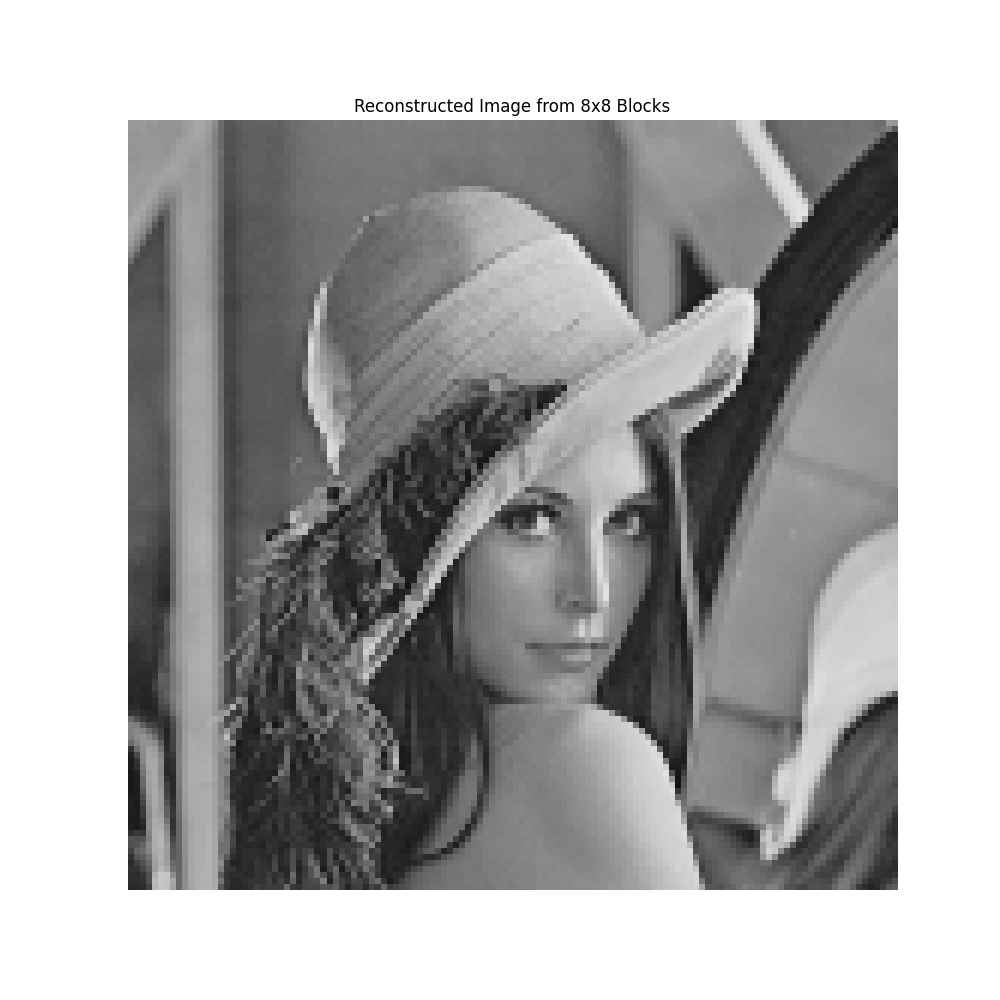

In [2]:
import numpy as np
import cv2

# Load the grayscale image
# im = cv2.imread("lenna_128x128.png", cv2.IMREAD_GRAYSCALE)

# # Write pixel values as 8-bit binary
# with open('image.txt', 'w') as f:
#     for i in im.reshape(-1, 1)[:, 0]:
#         f.write(f"{i:08b}\n")  # Convert to 8-bit binary

# arr = []
# with open('image.txt') as f:
#     for pixel in f.readlines():
#         arr.append(int(pixel, 2))
# plt.figure(figsize=(15,15))
# plt.imshow(np.array(arr).reshape((128,128)),cmap='gray',interpolation=None,vmax=255,vmin=0)
# ogimg = np.array(arr).reshape((128,128))


# im = cv2.imread("lenna_128x128.png", cv2.IMREAD_GRAYSCALE)
im = cv2.imread("lenna_128x128.png", cv2.IMREAD_GRAYSCALE)
block_size = 8
height, width = im.shape

with open('image.txt', 'w') as f:
    for row in range(0, height, block_size):
        for col in range(0, width, block_size):
            block = im[row:row+block_size, col:col+block_size]
            flat_block = block.flatten()
            for pixel in flat_block:
                f.write(f"{pixel:08b}\n")  

arr = []
with open('image.txt') as f:
    for pixel in f.readlines():
        arr.append(int(pixel.strip(), 2))

reconstructed = np.zeros_like(im)
index = 0
for row in range(0, height, block_size):
    for col in range(0, width, block_size):
        block = np.array(arr[index:index+64]).reshape((8, 8))
        reconstructed[row:row+8, col:col+8] = block
        index += 64
ogimg = reconstructed
plt.figure(figsize=(10, 10))
plt.imshow(reconstructed, cmap='gray', vmin=0, vmax=255)
plt.title("Reconstructed Image from 8x8 Blocks")
plt.axis('off')
plt.show()

Connecting with the COM ports

In [3]:
import serial
import struct
from time import sleep
# Setup serial port
# ComPort = serial.Serial('COM4', baudrate=9600, bytesize=8, parity='N', stopbits=1)
ComPort = serial.Serial('COM7', baudrate=9600, bytesize=8, parity='N', stopbits=1)
# if not ComPort.isOpen():
#     ComPort.open()
ComPort.flushOutput()
ComPort.flushInput()


To send data (img.txt) to board - __ensure read switch is on__

In [4]:
ComPort.flushOutput()
ComPort.flushInput()


# Read pixel values
with open(r'image.txt' , "r") as f:
    lines = f.readlines()
# lines = ['0']*128*128

assert len(lines) == 128 * 128, "Image.txt does not contain 16384 pixels!"

# Transmit to FPGA
lines_to_transmit = lines
  # Only transmit the first 64 pixels (ensure the same in dct module)
for i, line in enumerate(lines_to_transmit):
    binary_string = line.strip().zfill(8)       # Pad to 8 bits
    pixel = int(binary_string, 2)
    ComPort.write(struct.pack('B', pixel))
    print(i,f"{pixel}")
    sleep(0.001)  # Safe timing

print("✅ Completed transmission to FPGA.")


0 155
1 153
2 155
3 152
4 153
5 149
6 148
7 148
8 153
9 152
10 153
11 147
12 149
13 146
14 148
15 147
16 150
17 147
18 151
19 150
20 149
21 148
22 147
23 147
24 151
25 150
26 150
27 149
28 150
29 149
30 147
31 148
32 149
33 149
34 150
35 150
36 150
37 149
38 146
39 152
40 150
41 148
42 150
43 151
44 151
45 149
46 146
47 154
48 148
49 148
50 152
51 151
52 151
53 150
54 152
55 159
56 151
57 151
58 152
59 152
60 152
61 154
62 157
63 162
64 149
65 156
66 161
67 167
68 166
69 158
70 141
71 108
72 147
73 154
74 162
75 167
76 165
77 156
78 135
79 107
80 147
81 157
82 163
83 166
84 164
85 153
86 131
87 107
88 155
89 161
90 164
91 162
92 159
93 150
94 129
95 105
96 159
97 161
98 160
99 158
100 158
101 147
102 131
103 106
104 161
105 158
106 158
107 157
108 154
109 147
110 132
111 112
112 161
113 161
114 155
115 153
116 154
117 149
118 132
119 104
120 162
121 158
122 152
123 150
124 156
125 152
126 131
127 105
128 85
129 87
130 94
131 96
132 98
133 99
134 99
135 100
136 83
137 84
138 89
139 98
1

Code to generate statements for sim

In [ ]:
with open(r'image.txt', "r") as f:
    lines = f.readlines()

# Clean and convert each binary string to integer
pixels = [int(line.strip(), 2) for line in lines[0:64] if line.strip()]

# Generate uart_send_byte lines
for pixel in pixels:
    print(f"uart_send_byte(8'h{pixel:02X});", end='')

uart_send_byte(8'h9B);uart_send_byte(8'h99);uart_send_byte(8'h9B);uart_send_byte(8'h98);uart_send_byte(8'h99);uart_send_byte(8'h95);uart_send_byte(8'h94);uart_send_byte(8'h94);uart_send_byte(8'h99);uart_send_byte(8'h98);uart_send_byte(8'h99);uart_send_byte(8'h93);uart_send_byte(8'h95);uart_send_byte(8'h92);uart_send_byte(8'h94);uart_send_byte(8'h93);uart_send_byte(8'h96);uart_send_byte(8'h93);uart_send_byte(8'h97);uart_send_byte(8'h96);uart_send_byte(8'h95);uart_send_byte(8'h94);uart_send_byte(8'h93);uart_send_byte(8'h93);uart_send_byte(8'h97);uart_send_byte(8'h96);uart_send_byte(8'h96);uart_send_byte(8'h95);uart_send_byte(8'h96);uart_send_byte(8'h95);uart_send_byte(8'h93);uart_send_byte(8'h94);uart_send_byte(8'h95);uart_send_byte(8'h95);uart_send_byte(8'h96);uart_send_byte(8'h96);uart_send_byte(8'h96);uart_send_byte(8'h95);uart_send_byte(8'h92);uart_send_byte(8'h98);uart_send_byte(8'h96);uart_send_byte(8'h94);uart_send_byte(8'h96);uart_send_byte(8'h97);uart_send_byte(8'h97);uart_send_

### Code to receive the Data from the FPGA for q8.8

0:  155
1:  153
2:  155
3:  152
4:  153
5:  149
6:  148
7:  148
8:  153
9:  152
10:  153
11:  147
12:  149
13:  146
14:  148
15:  147
16:  150
17:  147
18:  151
19:  150
20:  149
21:  148
22:  147
23:  147
24:  151
25:  150
26:  150
27:  149
28:  150
29:  149
30:  147
31:  148
32:  149
33:  149
34:  150
35:  150
36:  150
37:  149
38:  146
39:  152
40:  150
41:  148
42:  150
43:  151
44:  151
45:  149
46:  146
47:  154
48:  148
49:  148
50:  152
51:  151
52:  151
53:  150
54:  152
55:  159
56:  151
57:  151
58:  152
59:  152
60:  152
61:  154
62:  157
63:  162
64:  149
65:  156
66:  161
67:  167
68:  166
69:  158
70:  141
71:  108
72:  147
73:  154
74:  162
75:  167
76:  165
77:  156
78:  135
79:  107
80:  147
81:  157
82:  163
83:  166
84:  164
85:  153
86:  131
87:  107
88:  155
89:  161
90:  164
91:  162
92:  159
93:  150
94:  129
95:  105
96:  159
97:  161
98:  160
99:  158
100:  158
101:  147
102:  131
103:  106
104:  161
105:  158
106:  158
107:  157
108:  154
109:  147
110:  132


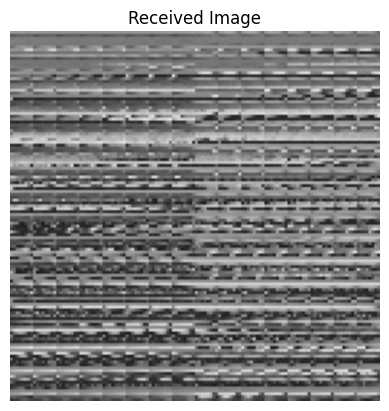

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import serial
import struct
from time import sleep

# === Setup serial port ===
# ComPort = serial.Serial('COM4', baudrate=9600, bytesize=8, parity='N', stopbits=1)
ComPort.flushInput()
ComPort.flushOutput()

# === Image Receive Buffer ===
arr = []
a2 = []
# === Receive 16384 bytes (128x128) ===
for i in range(16384):
    byte = ComPort.read(size=1)
    a2.append(byte)
    pixel = int.from_bytes(byte, byteorder='little', signed=False)
    arr.append(pixel)
    print(f"{i}:  {pixel}")
    sleep(0.001)  # Prevent UART overflow

print("✅ Completed reception")
print("Total pixels received:", len(arr))

# === Save to file ===
with open("obtained_image_iter2_noise.txt", 'w') as f:
    for idx, pixel in enumerate(arr):
        f.write(f"{pixel}\n")

# === Display image ===
if len(arr) == 128 * 128:
    img = np.array(arr, dtype=np.uint8).reshape((128, 128))
    plt.imshow(img, cmap='gray',interpolation=None,vmax=255,vmin=0)
    plt.title("Received Image")
    plt.axis('off')
    plt.show()
else:
    print("⚠️ Error: Did not receive exactly 128x128 pixels.")


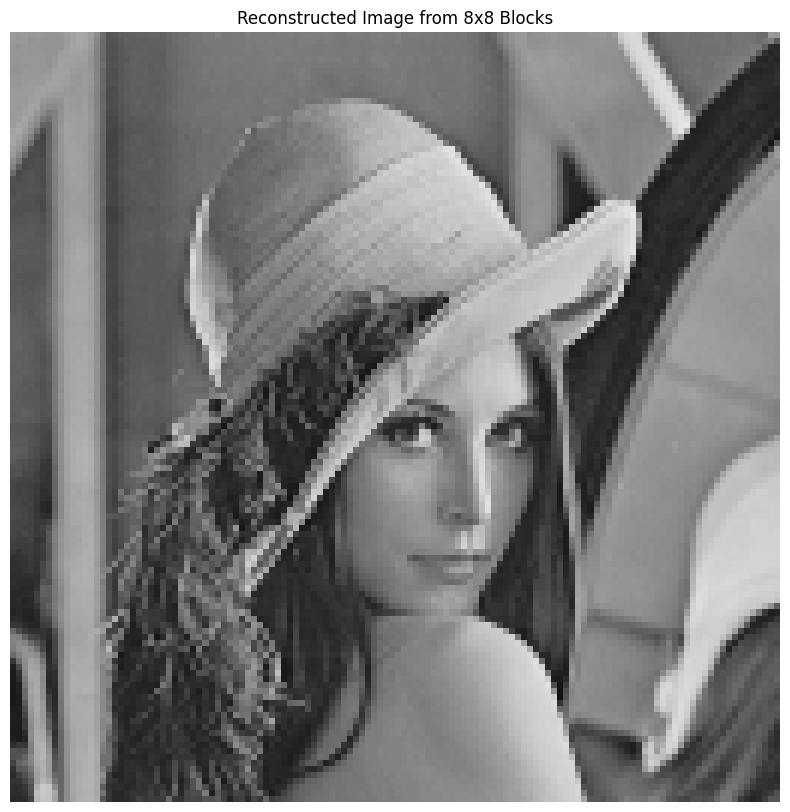

In [ ]:
reconstructed = np.zeros_like(im)
index = 0
for row in range(0, height, block_size):
    for col in range(0, width, block_size):
        block = np.array(arr[index:index+64]).reshape((8, 8))
        reconstructed[row:row+8, col:col+8] = block
        index += 64

plt.figure(figsize=(10, 10))
plt.imshow(reconstructed, cmap='gray', vmin=0, vmax=255)
plt.title("Reconstructed Image from 8x8 Blocks")
plt.axis('off')
plt.show()

### Code to receive the Data from the FPGA for q11.5

__First run this block__

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import serial
import struct
from time import sleep

sleep_time = 0.0015

ComPort.flushInput()
ComPort.flushOutput()

# === Image Receive Buffer (binary representation) ===
binary_data = []

# === Receive 16384 bytes (128x128 image) ===
for i in range(2*16384):
    byte = ComPort.read(size=1)
    binary_string = format(byte[0], '08b')  # Convert to 8-bit binary string
    binary_data.append(binary_string)
    print(f"{i}:  {binary_string}")
    sleep(sleep_time)  # Prevent UART overflow

print("✅ Completed reception")
print("Total bytes received:", len(binary_data))

# === Save to file ===
with open("obtained_image_binary.txt", 'w') as f:
    for b in binary_data:
        f.write(f"{b}\n")

0:  00010101
1:  00000000
2:  00000000
3:  11111111
4:  00000000
5:  11111111
6:  00000000
7:  00000000
8:  11111111
9:  00000001
10:  11111111
11:  00000000
12:  11111111
13:  00000000
14:  11111111
15:  00000000
16:  00000001
17:  11111111
18:  00000000
19:  11111111
20:  11111111
21:  00000000
22:  11111111
23:  00000000
24:  11111111
25:  00000000
26:  11111111
27:  11111111
28:  00000000
29:  11111111
30:  00000000
31:  11111111
32:  00000000
33:  00000000
34:  00000000
35:  00000000
36:  11111111
37:  11111111
38:  11111111
39:  11111111
40:  00000000
41:  11111111
42:  11111111
43:  11111111
44:  00000000
45:  00000000
46:  00000000
47:  00000000
48:  00000000
49:  11111111
50:  11111111
51:  00000000
52:  00000000
53:  00000000
54:  00000000
55:  11111111
56:  11111111
57:  11111111
58:  11111111
59:  11111111
60:  00000000
61:  00000000
62:  00000000
63:  11111111
64:  00010010
65:  00001100
66:  11110101
67:  00000100
68:  11111101
69:  00000000
70:  11111111
71:  00000000
72

Concatenate the value from two BRAM sections

In [6]:
# d2 = []
# for i in range(16384):
#     d2.append(binary_data[2*i]+binary_data[2*i+1])

d2 = []
for i in range(16384):
    d2.append(binary_data[i]+binary_data[i+16384])

Convert to floating point numbers

In [7]:
def q11_5_to_float(index, binary_str: str) -> float:
    # Convert binary string to signed 16-bit integer
    value = int(binary_str, 2)

    if value & (1 << 15):  # if the sign bit is set
        value -= 1 << 16   # convert to negative using two's complement
        print(f"Negative value detected at {index}: {value}")

    return value / 32.0  # divide by 2^5
    return value   # divide by 2^5



d3 = [q11_5_to_float(i, val) for i, val in enumerate(d2)]
d3 = np.array(d3)
d3.shape

Negative value detected at 3: -148
Negative value detected at 5: -64
Negative value detected at 8: -203
Negative value detected at 10: -114
Negative value detected at 12: -81
Negative value detected at 14: -27
Negative value detected at 17: -75
Negative value detected at 19: -49
Negative value detected at 20: -41
Negative value detected at 22: -34
Negative value detected at 24: -6
Negative value detected at 26: -49
Negative value detected at 27: -32
Negative value detected at 29: -72
Negative value detected at 31: -11
Negative value detected at 36: -19
Negative value detected at 37: -22
Negative value detected at 38: -23
Negative value detected at 39: -33
Negative value detected at 41: -20
Negative value detected at 42: -64
Negative value detected at 43: -4
Negative value detected at 49: -1
Negative value detected at 50: -67
Negative value detected at 55: -42
Negative value detected at 56: -9
Negative value detected at 57: -73
Negative value detected at 58: -42
Negative value detected 

(16384,)

reshaping into blocks

In [19]:
arr = d3 #+ 128
do_inverse_quantization = False
Q_mat = np.array([
    [4, 3, 3, 4, 5, 5, 6, 6],
    [3, 3, 4, 4, 5, 6, 6, 6],
    [4, 4, 4, 5, 5, 6, 6, 6],
    [4, 4, 4, 5, 6, 6, 6, 6],
    [4, 4, 5, 6, 6, 7, 7, 6],
    [5, 5, 6, 6, 6, 7, 7, 6],
    [6, 6, 6, 6, 7, 7, 7, 7],
    [6, 6, 6, 6, 7, 7, 7, 7]
])

# Create actual quantization values from log2: value = 2^Q_mat
quant_vals = np.power(2, Q_mat)

reconstructed = np.zeros(im.shape)
index = 0
block_arr = []
# height, width = 8, 8
for row in range(0, height, block_size):
    for col in range(0, width, block_size):
        block = np.array(arr[index:index+64]).reshape((8, 8))
        if do_inverse_quantization:
            block = np.multiply(block, quant_vals)
        block_arr.append(block)
        reconstructed[row:row+8, col:col+8] = block
        index += 64

In [20]:
reconstructed[0:8, 0:8] , block_arr[0] == block_arr[46] 

(array([[ 1.695625e+02,  9.687500e-01,  1.562500e+00, -4.625000e+00,
          4.125000e+00, -2.000000e+00,  3.968750e+00,  2.156250e+00],
        [-6.343750e+00,  1.428125e+01, -3.562500e+00,  3.718750e+00,
         -2.531250e+00,  1.250000e+00, -8.437500e-01,  2.656250e+00],
        [ 1.000000e+01, -2.343750e+00,  2.843750e+00, -1.531250e+00,
         -1.281250e+00,  1.031250e+00, -1.062500e+00,  1.812500e+00],
        [-1.875000e-01,  2.625000e+00, -1.531250e+00, -1.000000e+00,
          2.500000e+00, -2.250000e+00,  9.375000e-01, -3.437500e-01],
        [ 4.593750e+00,  3.125000e-02,  9.375000e-02,  1.468750e+00,
         -5.937500e-01, -6.875000e-01, -7.187500e-01, -1.031250e+00],
        [ 5.312500e-01, -6.250000e-01, -2.000000e+00, -1.250000e-01,
          6.875000e-01,  5.937500e-01,  3.437500e-01,  3.125000e-02],
        [ 6.250000e-01, -3.125000e-02, -2.093750e+00,  1.062500e+00,
          1.718750e+00,  8.750000e-01,  9.375000e-01, -1.312500e+00],
        [-2.812500e-01, -2.

plotting dct coeffs

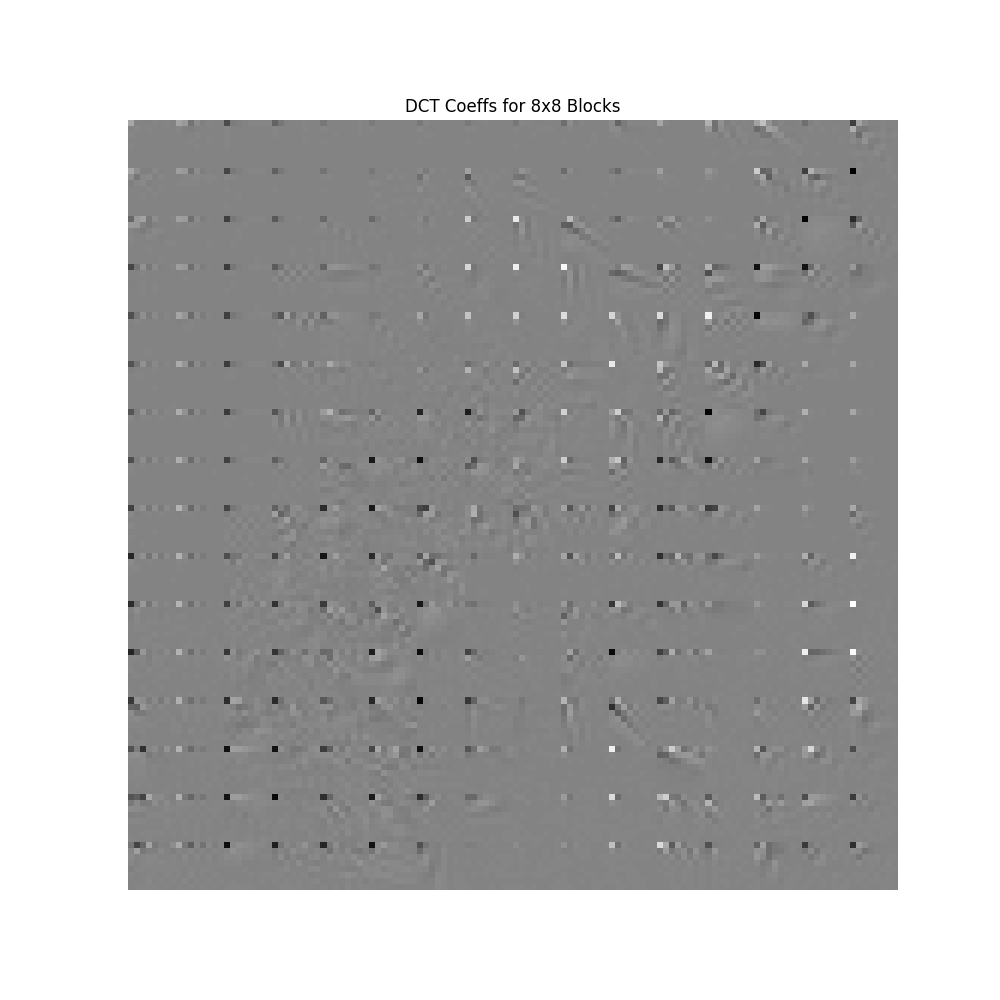

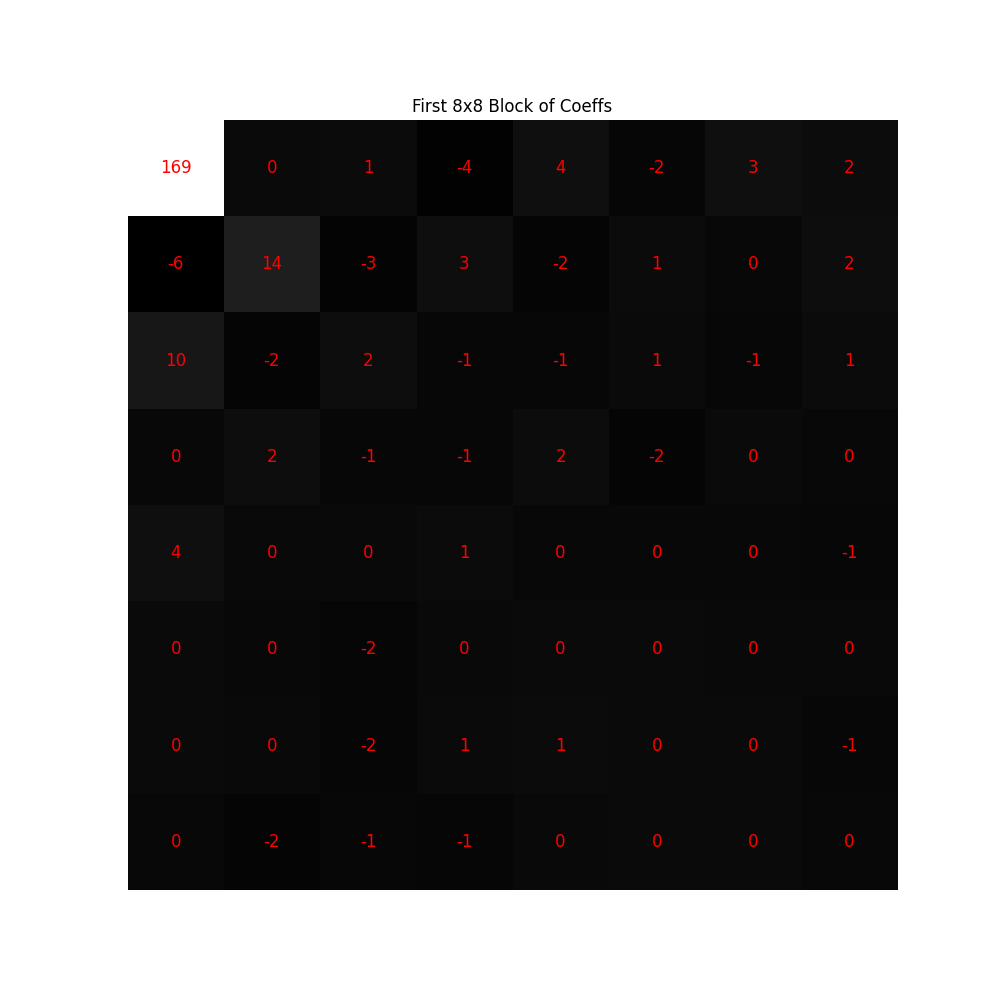

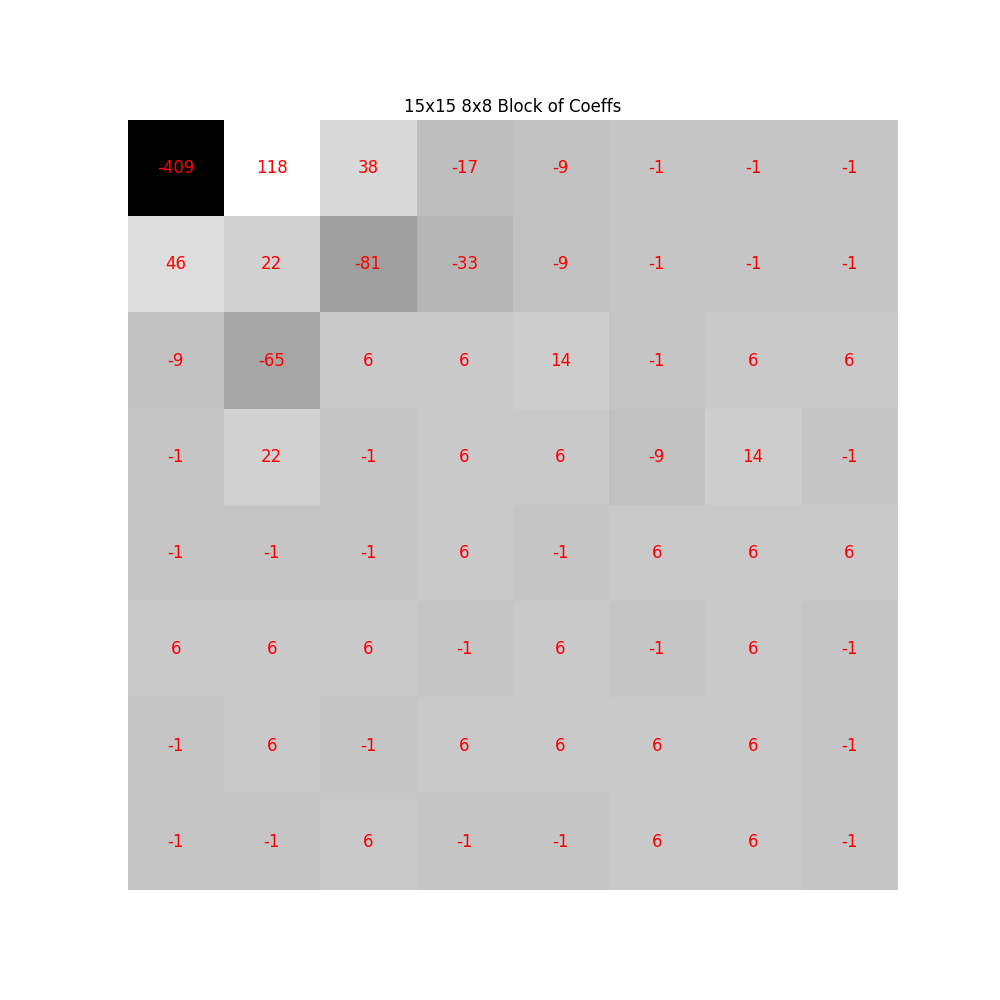

In [21]:
plt.figure(figsize=(10, 10))
plt.imshow(reconstructed, cmap='gray')
#draw lines on the plot to show the 8x8 blocks
# for i in range(-1, 127, 8):
#     plt.axhline(i, color='red', linewidth=0.5, linestyle='--')
# for i in range(-1, 127, 8):
#     plt.axvline(i, color='red', linewidth=0.5, linestyle='--')
plt.title("DCT Coeffs for 8x8 Blocks")
plt.axis('off')
plt.ion()
plt.show()

# np.savetxt('dct_cff.txt',reconstructed)

# plot the first block of pixel only
plt.figure(figsize=(10, 10))
plt.imshow(reconstructed[0:8,0:8], cmap='gray')
# write pixel values on the plot on the respectiver pixels
for i in range(8):
    for j in range(8):
        plt.text(j,i,f"{int(reconstructed[i,j]):d}", ha='center', va='center', fontsize=12, color='red')
plt.title("First 8x8 Block of Coeffs")
plt.axis('off')
plt.show()


# plot another block
row, col = 15, 15

plt.figure(figsize=(10, 10))
plt.imshow(reconstructed[row*8:(1+row)*8,col*8:(1+col)*8], cmap='gray')
# write pixel values on the plot on the respectiver pixels
for i in range(8):
    for j in range(8):
        plt.text(j,i,f"{int(reconstructed[row*8 + i,col*8 + j]):d}", ha='center', va='center', fontsize=12, color='red')
plt.title(f"{row}x{col} 8x8 Block of Coeffs")
plt.axis('off')
plt.show()


plotting image

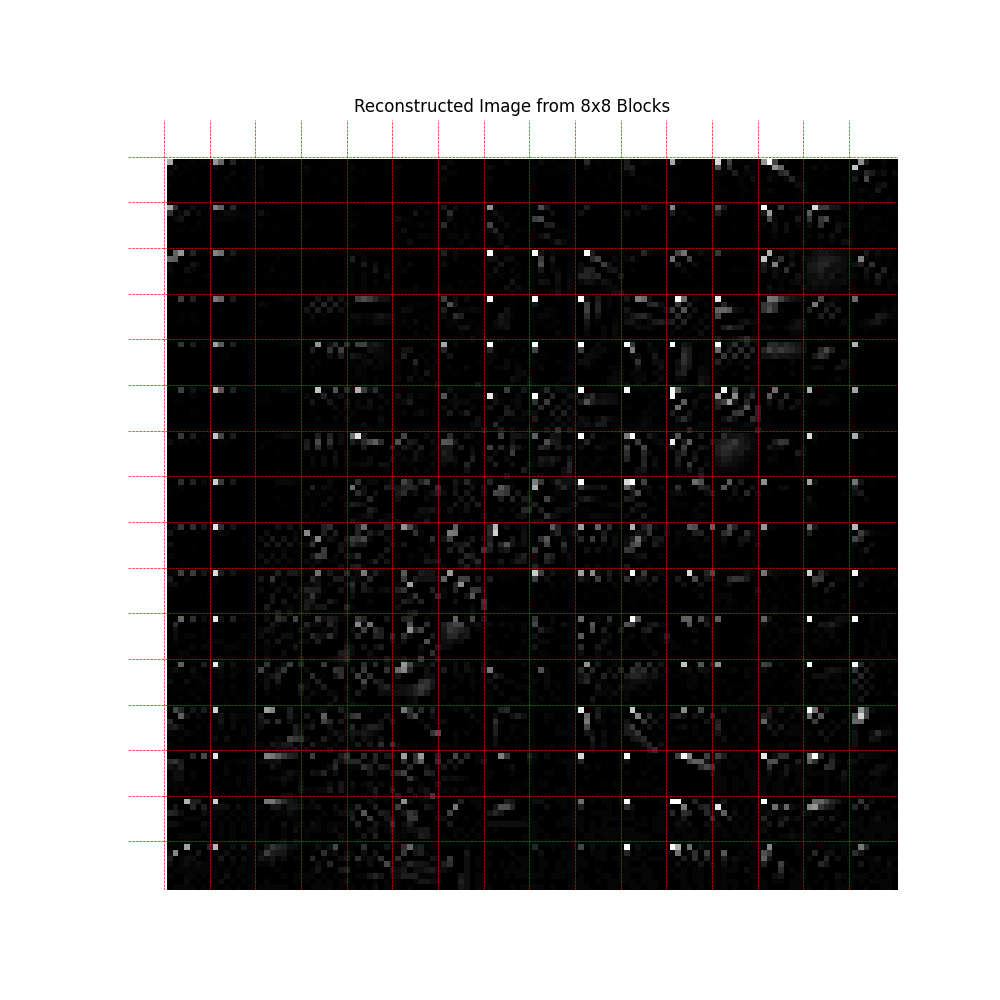

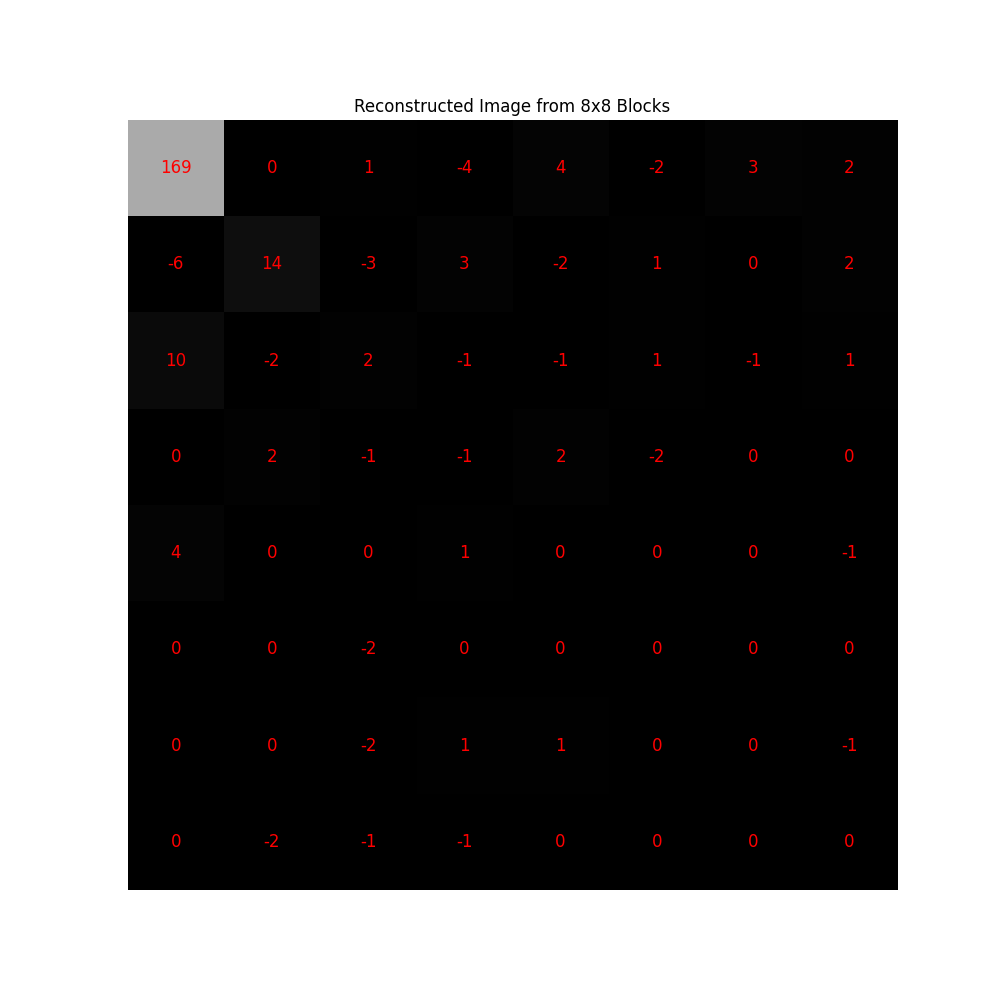

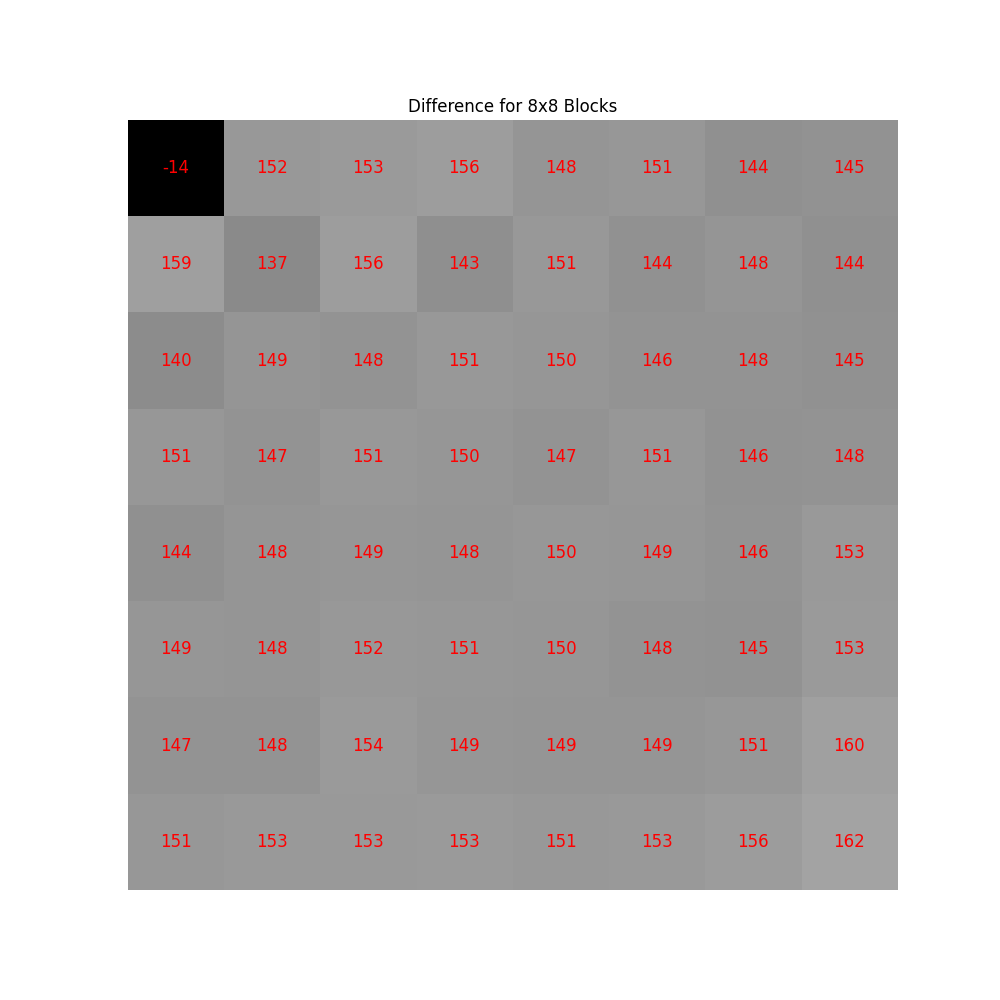

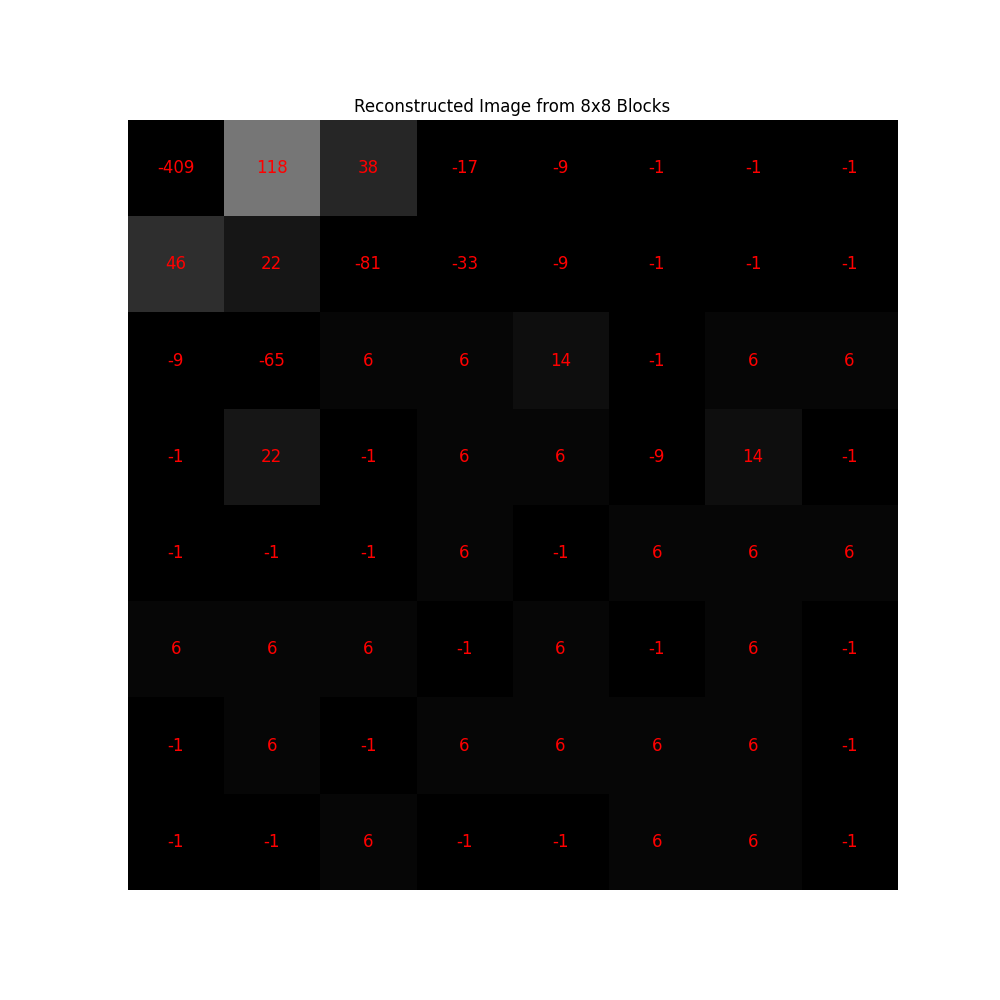

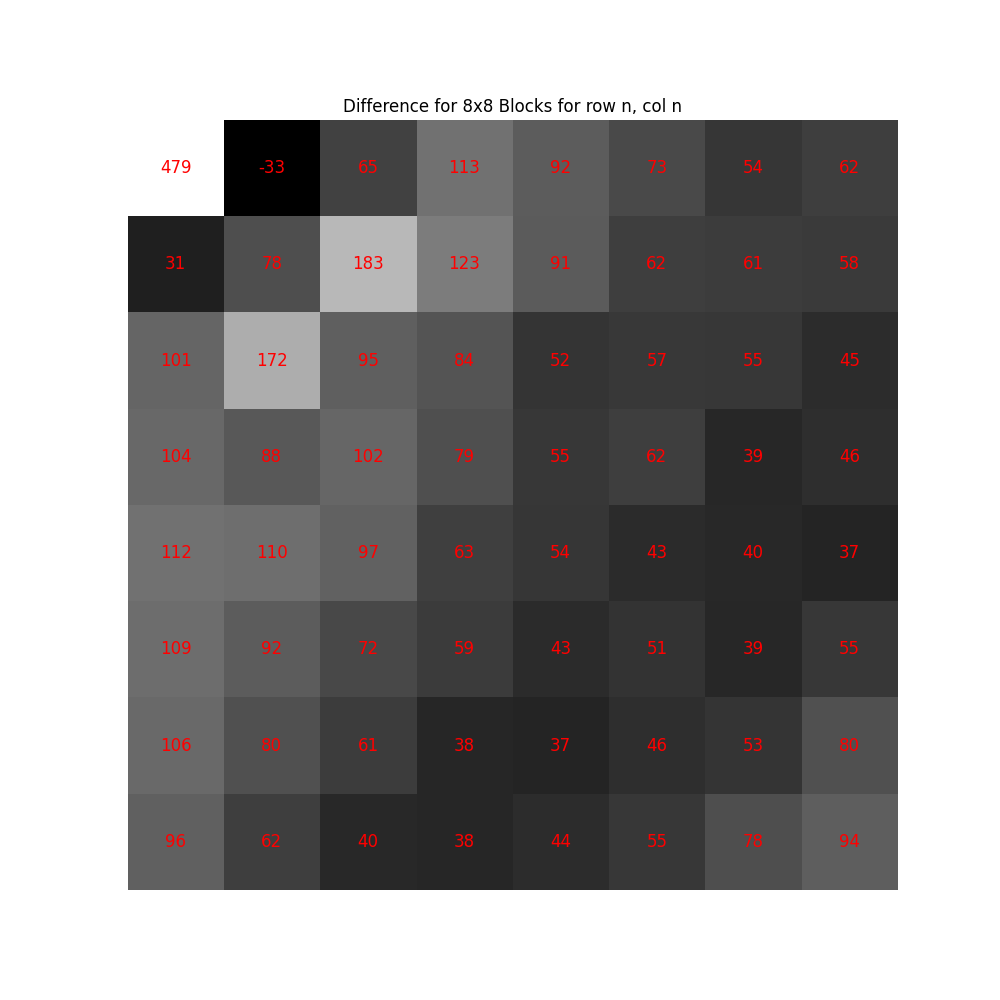

In [22]:
plt.figure(figsize=(10, 10))
plt.imshow(reconstructed, cmap='gray', vmin=0, vmax=255)
#draw lines on the plot to show the 8x8 blocks
for i in range(-1, 127, 8):
    plt.axhline(i, color='red', linewidth=0.5, linestyle='--')
for i in range(-1, 127, 8):
    plt.axvline(i, color='red', linewidth=0.5, linestyle='--')
plt.title("Reconstructed Image from 8x8 Blocks")
plt.axis('off')
plt.ion()
plt.show()

# np.savetxt('dct_cff.txt',reconstructed)

# plot the first block of pixel only
plt.figure(figsize=(10, 10))
plt.imshow(reconstructed[0:8,0:8], cmap='gray', vmin=0, vmax=255)
# write pixel values on the plot on the respectiver pixels
for i in range(8):
    for j in range(8):
        plt.text(j,i,f"{int(reconstructed[i,j]):d}", ha='center', va='center', fontsize=12, color='red')
plt.title("Reconstructed Image from 8x8 Blocks")
plt.axis('off')
plt.show()

# plot difference between original and reconstructed block
plt.figure(figsize=(10, 10))
plt.imshow(ogimg[0:8,0:8]-reconstructed[0:8,0:8], cmap='gray', vmin=0, vmax=255)
# write pixel values on the plot on the respectiver pixels
for i in range(8):
    for j in range(8):
        plt.text(j,i,f"{int(ogimg[i,j]-reconstructed[i,j]):d}", ha='center', va='center', fontsize=12, color='red')
plt.title("Difference for 8x8 Blocks")
plt.axis('off')
plt.show()


# plot another block
row, col = 15, 15

plt.figure(figsize=(10, 10))
plt.imshow(reconstructed[row*8:(1+row)*8,col*8:(1+col)*8], cmap='gray', vmin=0, vmax=255)
# write pixel values on the plot on the respectiver pixels
for i in range(8):
    for j in range(8):
        plt.text(j,i,f"{int(reconstructed[row*8 + i,col*8 + j]):d}", ha='center', va='center', fontsize=12, color='red')
plt.title("Reconstructed Image from 8x8 Blocks")
plt.axis('off')
plt.show()

plt.figure(figsize=(10, 10))
plt.imshow(ogimg[row*8:(1+row)*8,col*8:(1+col)*8]-reconstructed[row*8:(1+row)*8,col*8:(1+col)*8], cmap='gray', vmin=0, vmax=255)
# write pixel values on the plot on the respectiver pixels
for i in range(8):
    for j in range(8):
        plt.text(j,i,f"{int(ogimg[row*8 + i,col*8 + j]-reconstructed[row*8 + i,col*8 + j]):d}", ha='center', va='center', fontsize=12, color='red')
plt.title("Difference for 8x8 Blocks for row n, col n")
plt.axis('off')
plt.show()

Reconstructung from DCT Coeffs

In [23]:
from scipy.fftpack import idct,dct
def idct2(block: np.ndarray) -> np.ndarray:
    return idct(idct(block,axis=0, norm='ortho'),axis=1, norm='ortho')

def dct2(block: np.ndarray) -> np.ndarray:
    return dct(dct(block,axis=0, norm='ortho'),axis=1, norm='ortho')

using only top $k$ coeffs

In [30]:
k = 4
reconstructed_block_arr = []
for block in block_arr:
    block_topk = block.copy()
    block_topk[k:] = 0
    block_topk[:,k:] = 0
    # block_topk = block_topk.astype(np.int32)
    reconstructed_block_arr.append(idct2(block_topk) + 128)
reconstructed_block_arr = np.array(reconstructed_block_arr)

In [31]:
reconstructed_block_arr[0] == reconstructed_block_arr[255]

array([[False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False]])

In [32]:
blocksxyz = np.array(reconstructed_block_arr).reshape(16, 16, 8, 8)
reconstructed_img = blocksxyz.transpose(0, 2, 1, 3).reshape(128, 128)
reconstructed_img[64, 56]

167.2265522312863

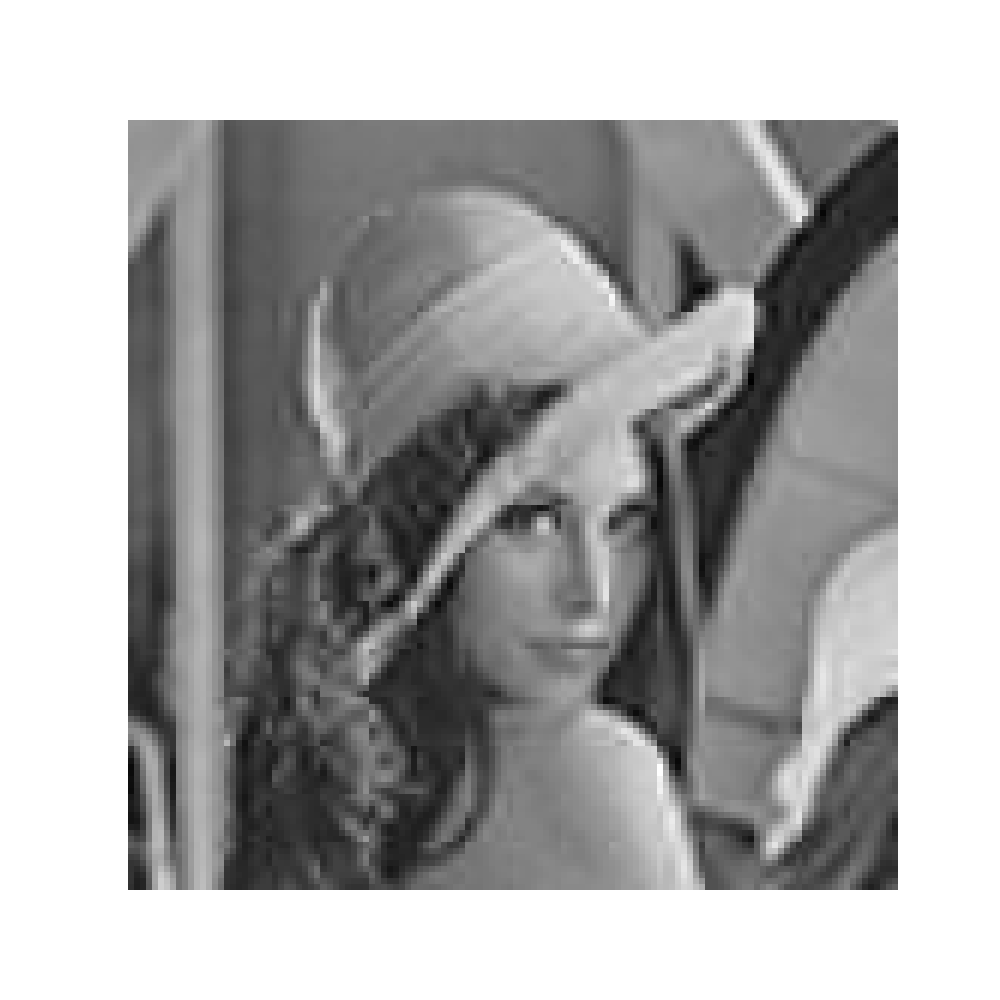

In [33]:
plt.figure(figsize=(10,10))
plt.imshow(reconstructed_img, cmap='gray',interpolation=None)
plt.axis('off')
plt.show()

In [34]:
# compare psnr
rmse = np.sqrt(np.mean((ogimg - reconstructed_img) ** 2))
psnr = 20 * np.log10(255 / rmse)
print(f"RMSE: {rmse}, PSNR: {psnr} dB")

RMSE: 11.65583510608394, PSNR: 26.799935710970267 dB


# Convert the img.txt to coe file

In [35]:
# def txt_to_coe(txt_filename, coe_filename, radix=10):
#     try:
#         with open(txt_filename, 'r') as txt_file:
#             lines = [line.strip() for line in txt_file if line.strip()]

#         decimal_values = [str(int(line, 2)) for line in lines]  # Convert binary to decimal

#         with open(coe_filename, 'w') as coe_file:
#             coe_file.write(f"memory_initialization_radix={radix};\n")
#             coe_file.write("memory_initialization_vector=\n")
            
#             for i, value in enumerate(decimal_values):
#                 if i == len(decimal_values) - 1:
#                     coe_file.write(f"{value};\n")  # End with semicolon
#                 else:
#                     coe_file.write(f"{value},\n")
        
#         print(f"Successfully converted {txt_filename} to {coe_filename}")
#     except Exception as e:
#         print(f"Error: {e}")


# # Example usage
# txt_to_coe(r'Image.txt', r'output.coe')